In [15]:
import pystac_client
import planetary_computer
import odc.stac
import matplotlib.pyplot as plt
import rasterio
from pystac.extensions.eo import EOExtension as eo


**Data access**

In [4]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

**Choose an area and time of interest**

In [67]:
bbox_of_interest =  [-75.28030313034645, 39.867465570687145, -74.9557457320632, 40.137927528193686] #Philadelphia coordinates
time_of_interest = "2021-01-01/2021-12-31"

bbox_of_interest =  [-75.28030313034645, 39.867465570687145, -74.9557457320632, 40.137927528193686]
time_of_interest = "2021-01-01/2021-12-31"

In [68]:
search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 10 Items


In [69]:
#Extracting least cloud cover value
selected_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {selected_item.id} from {selected_item.datetime.date()}"
    + f" with {selected_item.properties['eo:cloud_cover']}% cloud cover"
)

Choosing LE07_L2SP_014032_20211021_02_T1 from 2021-10-21 with 0.0% cloud cover


**Band Information**

In [70]:
bands_of_interest = ["lwir"]
data = odc.stac.stac_load(
    [selected_item], bands=bands_of_interest, bbox=bbox_of_interest
).isel(time=0)
data

<xarray.Dataset>
Dimensions:      (y: 1002, x: 926)
Coordinates:
  * y            (y) float64 4.443e+06 4.443e+06 ... 4.413e+06 4.413e+06
  * x            (x) float64 4.76e+05 4.761e+05 ... 5.038e+05 5.038e+05
    spatial_ref  int32 32618
    time         datetime64[ns] 2021-10-21T14:34:05.344052
Data variables:
    lwir         (y, x) uint16 41939 0 0 0 0 0 ... 42631 42840 42944 42944 42476

In [9]:

band_info = selected_item.assets["lwir"].extra_fields["raster:bands"][0]
band_info


{'unit': 'kelvin',
 'scale': 0.00341802,
 'nodata': 0,
 'offset': 149.0,
 'data_type': 'uint16',
 'spatial_resolution': 30}

In [10]:
temperature = data["lwir"].astype(float)
temperature *= band_info["scale"]
temperature += band_info["offset"]
temperature[:5, :5]

<xarray.DataArray 'lwir' (y: 5, x: 5)>
array([[292.34834078, 149.        , 149.        , 149.        ,
        149.        ],
       [291.94501442, 292.0099568 , 291.96894056, 291.9074162 ,
        292.57734812],
       [291.55536014, 291.66131876, 291.99628472, 291.9586865 ,
        292.57734812],
       [291.50750786, 291.58954034, 291.91425224, 291.92792432,
        292.57734812],
       [291.84247382, 291.531434  , 291.91425224, 291.89374412,
        292.94649428]])
Coordinates:
  * y            (y) float64 4.443e+06 4.443e+06 4.443e+06 4.443e+06 4.443e+06
  * x            (x) float64 4.76e+05 4.761e+05 4.761e+05 4.761e+05 4.762e+05
    spatial_ref  int32 32618
    time         datetime64[ns] 2021-10-21T14:34:05.344052
Attributes:
    nodata:   0

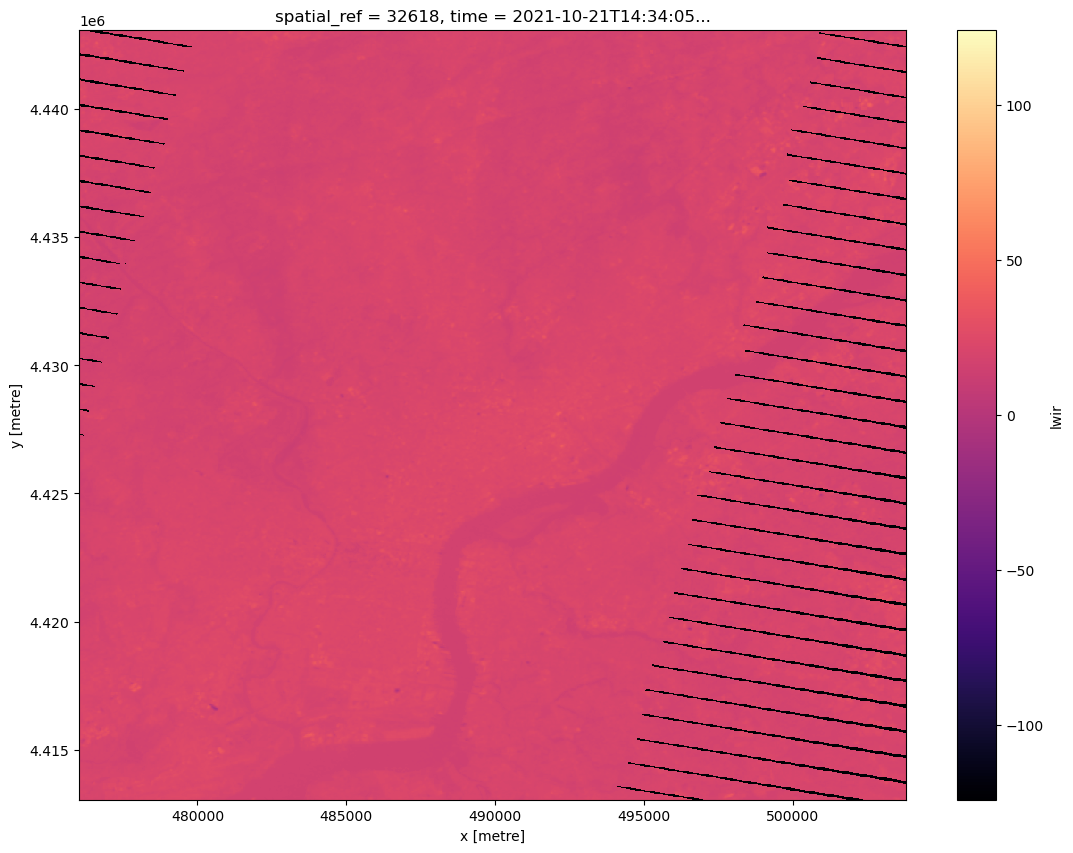

In [11]:
celsius = temperature - 273.15
celsius.plot(cmap="magma", size=10);

**Download Philadelphia's temperature raster layer**

In [14]:
from rasterio.transform import from_bounds 
# Saving the raster data to GeoTIFF
output_file = "temp-landsat/temperature.tif"
transform = from_bounds(*bbox_of_interest, width=celsius.shape[1], height=celsius.shape[0])
crs = rasterio.crs.CRS.from_epsg(4326)  # Assuming EPSG:4326 for the CRS

with rasterio.open(output_file, 'w', driver='GTiff',
                   width=celsius.shape[1], height=celsius.shape[0],
                   count=1, dtype=celsius.dtype,
                   crs=crs, transform=transform) as dst:
    dst.write(celsius.values, 1)

print(f"Raster saved to {output_file}")


Raster saved to temp-landsat/temperature.tif


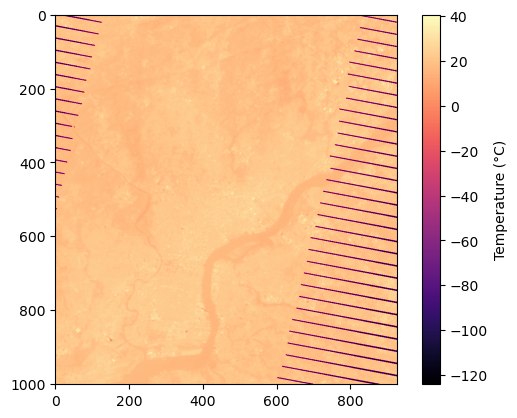

In [17]:
import rasterio as rio

# Open the saved GeoTIFF file
temp_file = 'temp-landsat/temperature.tif'
temp_dataset = rio.open(temp_file)

# Read the band of the raster data
temp = temp_dataset.read(1)  # Assuming it's a single-band raster

# Plotting the raster
plt.imshow(temp, cmap='magma')
plt.colorbar(label='Temperature (°C)')
plt.show()

**Clip and create a mask layer from raster layer**

In [22]:
import fiona
import rasterio
from rasterio.mask import mask

temp_file = 'temp-landsat/temperature.tif'
shpfile = 'Census_Tracts/Census_Tracts_2010.shp'
out_raster = 'temp-landsat/maskPhily-temp.tif'

with fiona.open(shpfile, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open(temp_file) as src:
    out_image, out_transform = mask(src, shapes, crop=True)
    out_meta = src.meta

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "compress": 'lzw',
                 "transform": out_transform})

with rasterio.open(out_raster, "w", **out_meta) as dest:
    dest.write(out_image)

**Plot the masked raster data over shapefile**

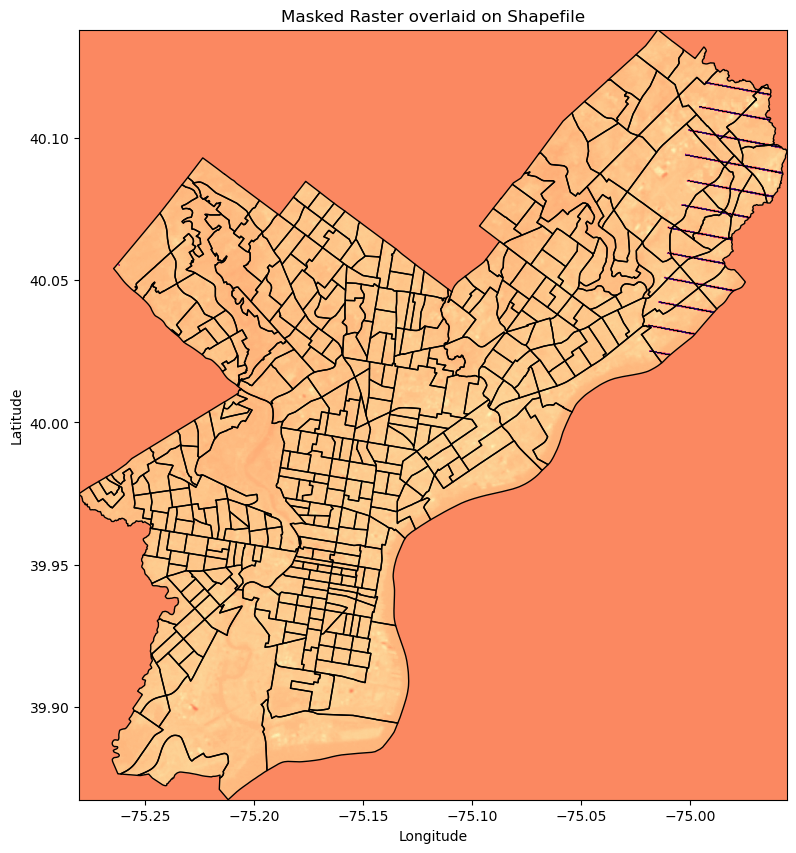

In [53]:
import geopandas as gpd
from rasterio.plot import show
from rasterio.mask import mask

# Path to the shapefile and the masked raster
shpfile = 'Census_Tracts/Census_Tracts_2010.shp'
masked_raster = 'temp-landsat/maskPhily-temp.tif'

# Read the shapefile using geopandas
gdf = gpd.read_file(shpfile)

# Open the masked raster
with rasterio.open(masked_raster) as src:
    # Mask the raster with the shapefile geometries
    out_image, out_transform = mask(src, gdf.geometry, crop=True)

# Plot the raster overlaid on the shapefile
plt.figure(figsize=(10, 10))
show(out_image, transform=out_transform, ax=plt.gca(), cmap='magma')
gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='black')
plt.title('Masked Raster overlaid on Shapefile')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()



**Extracting temperature data from raster for each Census tract**

In [59]:
import fiona
import shapely
from shapely.geometry import shape
import os, os.path
import numpy as np


inraster = 'temp-landsat/maskPhily-temp.tif'
input_zone_polygon = 'Census_Tracts/Census_Tracts_2010.shp'
output_shp_res = 'temp-landsat/tempCensus-tract.shp'


# Open the raster dataset
temp_dataset = rasterio.open(inraster)

# Prepare the polygon shapefile and then do the overlay of the raster data and the vector data
lyr = fiona.open(input_zone_polygon)
schema = lyr.schema
schema['properties']['temp'] = 'float'

with fiona.open(output_shp_res, 'w', driver="ESRI Shapefile", crs=lyr.crs, schema=schema) as output:
    for idx, feat in enumerate(lyr):
        props = feat['properties']
        geom = feat['geometry']
        shape = [geom]  # the rasterio needs the list, therefore, create a list

        # Mask the raster using the polygon
        outtemp_image, out_transform = rasterio.mask.mask(temp_dataset, shape, crop=True)

        # Convert to Celsius using given information
        temperature = outtemp_image.astype(float)
        # Calculate the mean temperature value
        mean_val = float(np.mean(temperature))

        # Update the calculated temperature value to the field
        props['temp'] = mean_val
        output.write({'properties': props,
                      'geometry': geom
                      })



C:\Users\tur08893\AppData\Local\Temp\ipykernel_13476\2254892037.py:38: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  props['temp'] = mean_val
C:\Users\tur08893\AppData\Local\Temp\ipykernel_13476\2254892037.py:38: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  props['temp'] = mean_val
C:\Users\tur08893\AppData\Local\Temp\ipykernel_13476\2254892037.py:38: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  props['temp'] = mean_val
C:\Users\tur08893\AppData\Local\Temp\ipykernel_13476\2254892037.py:38: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  props['temp'] = mean_val
C:\Users\tur08893\AppData\Local\Temp\ipykernel_13476\2254892037.py:38: Fiona

**Plot the temperatures over census tracts**

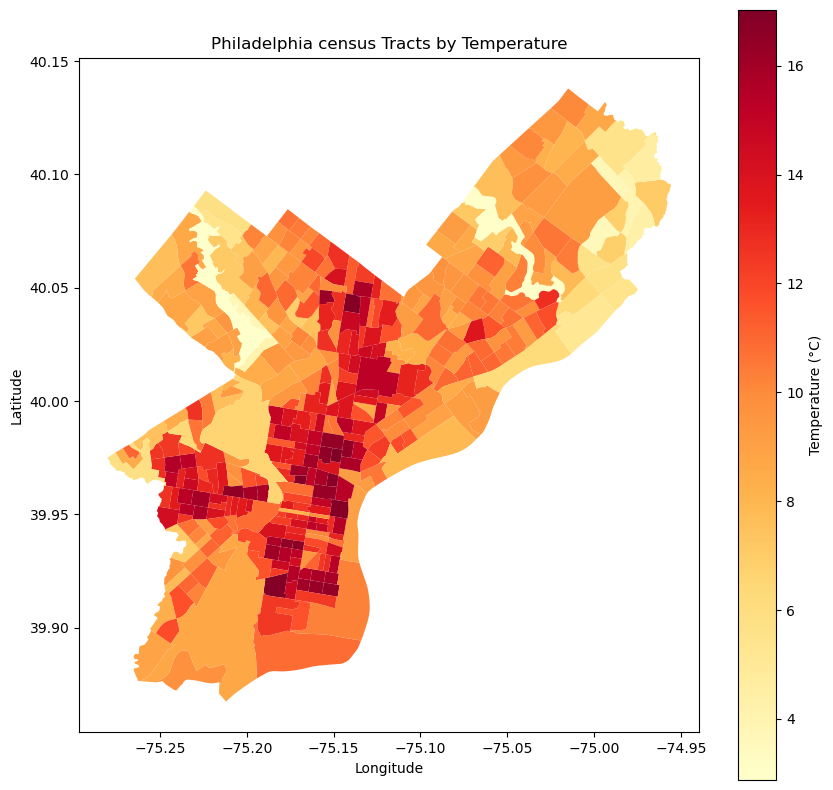

In [62]:

# Read the shapefile
shapefile_path = 'temp-landsat/tempCensus-tract.shp'
gdf = gpd.read_file(shapefile_path)

# Plot the shapefile with the 'temp' column and colormap
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='temp', cmap='YlOrRd', legend=True, ax=ax)

# Add title and labels
plt.title('Philadelphia census Tracts by Temperature')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Customize the legend
cbar = ax.get_figure().get_axes()[1]  # Get the colorbar axis
cbar.set_ylabel('Temperature (°C)')  # Set the label for the colorbar

# Display the plot
plt.show()
